<a href="https://colab.research.google.com/github/DevMindset21/Sentiment_based_Strategy/blob/main/Sentiment_Analysis_Based_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Problem Statement #
The problem statement is to build a trading strategy that uses NLP to extracts the information inside the news headlines, assigns a sentiment to that and use the sentiments and the information inside the news headlines for a trading strategy.

The data used for this case study will be from three sources:

1. News headlines data compiled from RSS feeds of several news websites: This news headlines data is complied by different news website and contains the most financially relevant news filtered. For the purpose of this study, we will only look at the headline, not the details in the story. Another important characteristic of this dataset is that the relevant tickers in the story are extracted. Our dataset contains 82,643 headlines from to 2011-05-02 to 2018-12-28
2. Yahoo finance website for the stock return: (The return data can be obtained from other website such as yahoo finance)a
kaggle: labelled data of of news sentiments obtained for a classification based sentiment analysis model. This data may not be authentic and is used only for demonstration purpose in this case study.
3. Stock market lexicon created based on stock market conversations in microblogging services.

#2. Getting Started- Loading the data and python packages#

## 2.1. Loading the python packages ##
As a first step we check if the additional packages needed are present, if not install them. These are checked separately as they aren't included in requirement.txt as they aren't used for all case studies

In [ ]:
import spacy
import numpy as np
nlp = spacy.load("en_core_web_sm")
import en_core_web_sm
nlp = en_core_web_sm.load()

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
pip install keras

In [ ]:
pip install backtrader

In [ ]:
#NLP libraries
from textblob import TextBlob
import spacy
import nltk
import warnings
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import csv
import pandas as pd
import tensorflow as tf

#Libraries for processing the news headlines
from lxml import etree
import json
from io import StringIO
from os import listdir
from os.path import isfile, join
from pandas.tseries.offsets import BDay
from scipy.stats.mstats import winsorize
from copy import copy

# Libraries for Classification for modeling the sentiments
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Keras package for the deep learning model for the sentiment prediction.
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout, Activation
from tensorflow.keras.layers import Embedding

# Load libraries
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf

#Additional Libraries
import json
import zipfile
import os.path

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
%matplotlib inline

## 2.2. Loading the stock price data ##
The stock price data is loaded in this step from Yahoo Finance in this step. The loaded data is saved in csv for further use.

In [ ]:
df_ticker_return = pd.read_csv('/content/Step2.2_ReturnData.csv')
df_ticker_return.head(10)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
0,2010-01-04,26.40,26.53,26.27,26.47,123432400,0.0,0.0,AAPL
1,2010-01-05,26.54,26.66,26.37,26.51,150476200,0.0,0.0,AAPL
2,2010-01-06,26.51,26.62,26.06,26.09,138040000,0.0,0.0,AAPL
3,2010-01-07,26.19,26.22,25.85,26.04,119282800,0.0,0.0,AAPL
4,2010-01-08,26.01,26.22,25.85,26.22,111902700,0.0,0.0,AAPL
5,2010-01-11,26.32,26.34,25.78,25.98,115557400,0.0,0.0,AAPL
6,2010-01-12,25.87,25.94,25.53,25.69,148614900,0.0,0.0,AAPL
7,2010-01-13,25.71,26.09,25.24,26.05,151473000,0.0,0.0,AAPL
8,2010-01-14,25.98,26.03,25.85,25.90,108223500,0.0,0.0,AAPL
9,2010-01-15,26.09,26.17,25.46,25.47,148516900,0.0,0.0,AAPL


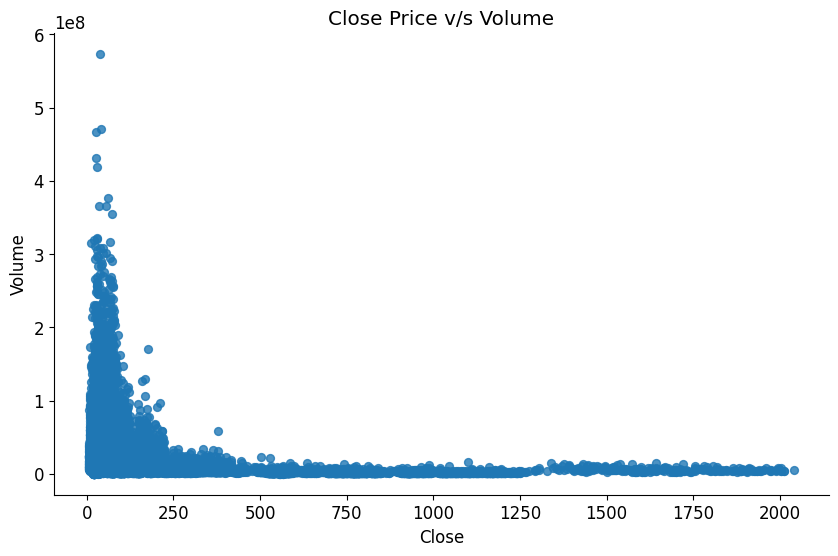

In [ ]:
# @title Close vs Volume
from matplotlib import pyplot as plt
df_ticker_return.plot(kind='scatter', x='Close', y='Volume', s=32, alpha=.8)
plt.title('Close Price v/s Volume')
plt.gca().spines[['top', 'right',]].set_visible(False)

The data contains the tickers and their return. In this next step, we clean the data make sure that the starting point is 2010 and the NAs in the data are dropped. Let us look at the news data now.

# 3. Loading the preprocessed data #
We divide the data preparation into couple of steps as follows:

1. Loading and preprocessing the news data
2. Preparing the combined data

Data preparation is time consuming. That is why the preprocessed data is used directly

In [ ]:
data_df = pd.read_csv('/content/Step3_NewsAndReturnData.csv',sep='|')
data_df = data_df.dropna()
data_df.head(10)

,ticker,headline,date,eventRet,Close
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,201.19
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.013003,33.88
2,MSFT,The likely winners in Microsoft's (MSFT -1.4%)...,2011-05-10,-0.019823,20.63
3,MSFT,Microsoft (MSFT -1.2%) and Skype signed their ...,2011-05-10,-0.019823,20.63
5,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,-0.006607,206.07
6,GOOG,"It's been some time coming, but Google (GOOG -...",2011-05-16,-0.008086,258.24
7,MSFT,Accusing underwriters of digging out their lat...,2011-05-19,-0.001443,20.00
8,MSFT,"If you bought LinkedIn (LNKD, now legging high...",2011-05-19,-0.001443,20.00
9,MSFT,"From Jens Heycke, the top 5 things you could b...",2011-05-19,-0.001443,20.00
10,MSFT,"""OK. This is almost hilarious. P/E Ratio for $...",2011-05-19,-0.001443,20.00


In [ ]:
print(data_df.shape, data_df.ticker.unique().shape)

(2759, 5) (10,)


In this step, we prepared a clean dataframe that has ticker, headline, event return, return for a given day and future return for 10 unique stock tickers with total 2759 rows of data

# 4. Evaluate Models for Sentiment Analysis #
In this section we will go through following three different approaches of getting the sentiments for the news which we will use for building the trading strategy.

Predefined model-TextBlob package
Tuned Model-Classification algorithms and LSTM
Model based on financial lexicon
We will also explore the difference between different ways of performing the sentiment analysis. Let us go through the steps.

## 4.1 - Predefined model-TextBlob package ##
The texblob sentiment function is pretrained model based on Naïve-Bayes classification algorithm to convert a sentence to a numerical value of sentiment between -1 to +1 and map adjectives frequently found in movie reviews(source code: https://textblob.readthedocs.io/en/dev/_modules/textblob/en/sentiments.html) to sentiment polarity scores, ranging from -1 to +1 (negative ↔ positive) and a similar subjectivity score (objective ↔ subjective). We apply this on all headline articles. Let us compute the sentiment for all the headlines in the data

In [ ]:
text1 = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their \
highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the \
company should be reversed."
TextBlob(text1).sentiment.polarity

0.5

The sentiment polarity is a number between -1 (Very Negative) and +1 (Very Positive). We apply this on all headline we have in the data processed in the previous step. Let us compute the sentiment for all the headlines in the data

In [ ]:
data_df['sentiment_textblob'] = [TextBlob(s).sentiment.polarity for s in data_df['headline']]

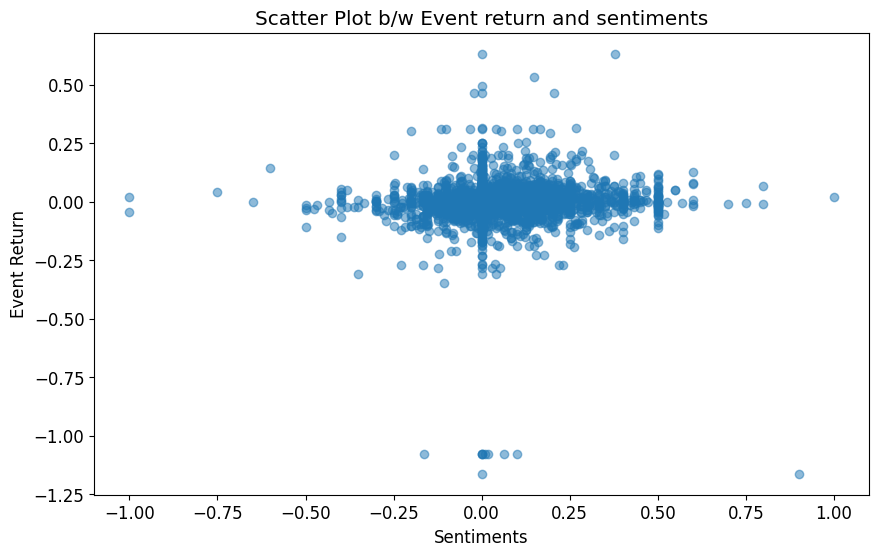

In [ ]:
# Let us analyse the scatterplot of the sentiments and the return
plt.scatter(data_df['sentiment_textblob'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Plot b/w Event return and sentiments')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

In [ ]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_textblob'])
print(corrlation)

0.042749340813834275


**The correlation is positive, which means that news with positive sentiments lead to positive return and is expected. However,the correlation isn't very high.**

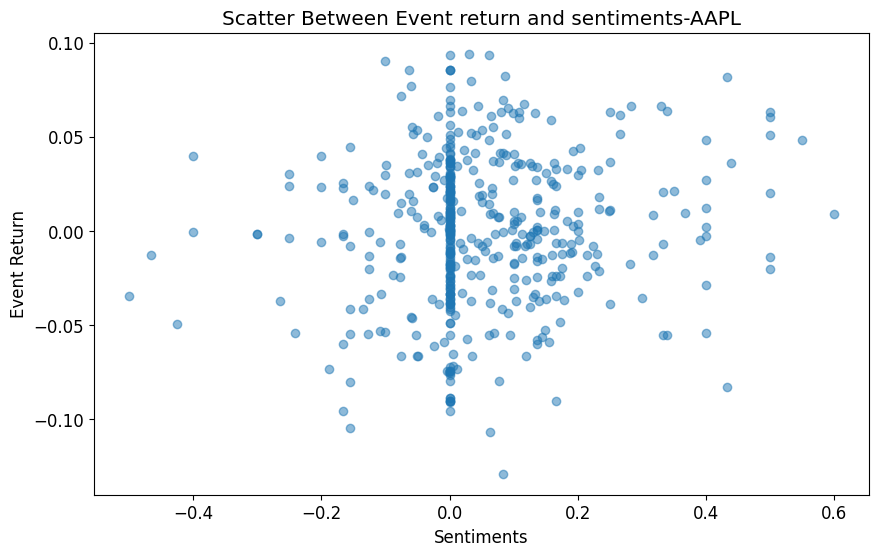

In [ ]:
data_df_stock  = data_df[data_df['ticker'] == 'AAPL']
plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AAPL')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

**Overall, from the results we can see that there isn't a strong correlation between the news and the sentiments. Also, there are a lot of sentiments centred around 0**.

In [ ]:
text = "Bayer (OTCPK:BAYRY) started the week up 3.5% to €74/share in Frankfurt, touching their highest level in 14 months, after the U.S. government said a $25M glyphosate decision against the company should be reversed."
TextBlob(text).sentiment_assessments

Sentiment(polarity=0.5, subjectivity=0.5, assessments=[(['touching'], 0.5, 0.5, None)])

We see that the statement has a positive sentiment of .5 but looking at the words that give rise to the sentiments, the word "touching" and not "high" causes positive sentiment.

## 4.2 - Supervised Learning-Classification algorithms and LSTM ##

In this step, we develop customised model for sentiment analysis, based on available labelled data. The label data for this is obtained from kaggle website. Let us look at the data.

In [ ]:
sentiments_data = pd.read_csv('/content/LabelledNewsData.csv',encoding = "ISO-8859-1")
sentiments_data.head(10)

,datetime,headline,ticker,sentiment
0,1/16/2020 5:25,$MMM fell on hard times but could be set to re...,MMM,0
1,1/11/2020 6:43,Wolfe Research Upgrades 3M $MMM to ¡§Peer Perf...,MMM,1
2,1/9/2020 9:37,3M $MMM Upgraded to ¡§Peer Perform¡¨ by Wolfe ...,MMM,1
3,1/8/2020 17:01,$MMM #insideday follow up as it also opened up...,MMM,1
4,1/8/2020 7:44,$MMM is best #dividend #stock out there and do...,MMM,0
5,1/6/2020 15:54,$MMM - 3M: The Fallen Dividend King Will Be Ba...,MMM,1
6,1/2/2020 14:35,$MMMcelebrates New Year with 7 month high clos...,MMM,1
7,1/2/2020 10:13,$MMM above 180 baby is going higher,MMM,1
8,12/28/2019 15:04,"$MMMhasn't really done much this year, but it ...",MMM,1
9,12/27/2019 0:28,3M $MMM Rating Increased to Neutral at JPMorga...,MMM,1


In [ ]:
print(sentiments_data.shape[0],',', sentiments_data.ticker.unique().shape[0])

9470 , 30


The data has headlines for the news across 30 different stocks, with total 9470 rows, and has sentiments lacelled 0 and 1. The headlines are already in almost cleaned.

In order to run a supervised learning model, we first need to convert the news headlines into feature representation.

In [ ]:
all_vectors = np.array([
    np.mean([token.vector for token in nlp(s) if token.has_vector], axis=0)
    for s in sentiments_data['headline']
])

In [ ]:
# Distribution of positive and negative sentiments
sentiments_data["sentiment"].value_counts()

,count
sentiment,
1,5482
0,3988


Now that we have prepared the independent variable we train multiple classification models and compare their performance. We first divide the data into training set and test set and futher run the key classification models.

In [ ]:
# split out validation dataset for the end
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(all_vectors)

Y= sentiments_data["sentiment"]
# X = all_vectors

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
validation_size = 0.3
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

# Spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('NN', MLPClassifier(max_iter=500))) # Neural network
models.append(('RF', RandomForestClassifier())) # Ensemble Models

In [ ]:
results = []
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
   # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = accuracy_score(res.predict(X_train), Y_train)
    train_results.append(train_result)

    # Test results
    test_result = accuracy_score(res.predict(X_test), Y_test)
    test_results.append(test_result)

    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)
    print(confusion_matrix(res.predict(X_test), Y_test))

LR: 0.732239 (0.017490) 0.746719 0.730025
[[ 757  290]
 [ 477 1317]]
KNN: 0.752297 (0.016875) 0.847488 0.738472
[[ 853  362]
 [ 381 1245]]
CART: 0.646099 (0.010024) 0.999849 0.631116
[[ 709  523]
 [ 525 1084]]
SVM: 0.804948 (0.012460) 0.900739 0.801478
[[ 858  188]
 [ 376 1419]]
NN: 0.809171 (0.014071) 0.999698 0.809926
[[ 935  241]
 [ 299 1366]]
RF: 0.758639 (0.008391) 0.999849 0.744104
[[ 684  177]
 [ 550 1430]]


In [ ]:
def plotResults(names, train_results, test_results):
  fig = plt.figure()
  ind = np.arange(len(names))  # the x locations for the groups
  width = 0.35  # the width of the bars

  # Add the subplot
  ax = fig.add_subplot(111)
  fig.suptitle('Algorithm Comparison')

  # Plot the bars
  bars1 = plt.bar(ind - width / 2, train_results, width=width, label='Train Accuracy')
  bars2 = plt.bar(ind + width / 2, test_results, width=width, label='Test Accuracy')

  # Add the accuracy numbers on top of the bars
  for i, bar in enumerate(bars1):
      height = bar.get_height()
      ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{height:.2f}',
              ha='center', va='bottom', fontsize=10, color='black')  # For train accuracy

  for i, bar in enumerate(bars2):
      height = bar.get_height()
      ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{height:.2f}',
              ha='center', va='bottom', fontsize=10, color='black')  # For test accuracy

  # Customize plot appearance
  ax.set_xticks(ind)
  ax.set_xticklabels(names)
  ax.set_ylim(0, 1.1)  # Set y-axis limit to make space for text labels
  fig.set_size_inches(15, 8)

  # Add a legend
  plt.legend()

  # Show the plot
  plt.show()


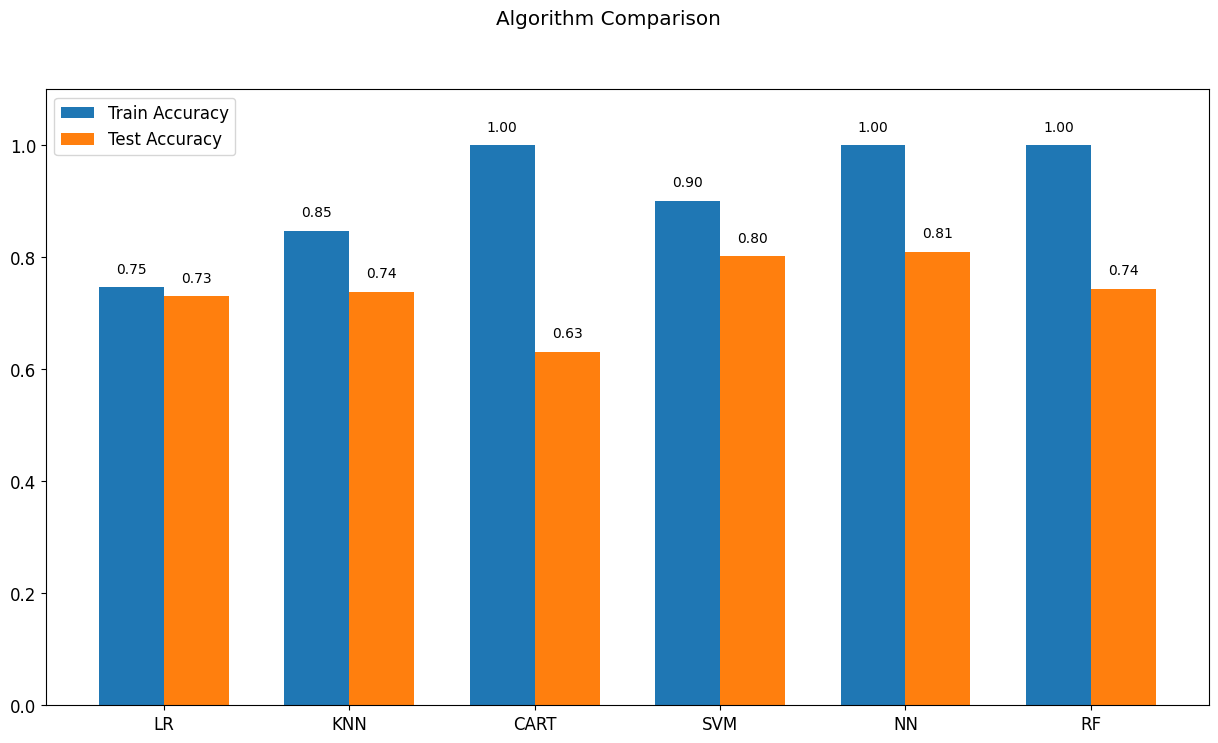

In [ ]:
# compare algorithms
plotResults(names, train_results, test_results)

As we can see the NN model is the best performer with the a training accuracy of 99% and test accuracy of 80%. The performance of Random forest, SVM and Logistic regression are good as well. CART and KNN don't perform as good as other models. CART has higher overfitting as well.

**LSTM based model**

In the above code snippet, we used the some of the model function which look at the individual works in the sentence for training. However, for NLP, RNN based model are preferred over other machine learning models as RNN stores the information for current feature as well neighboring features for prediction.

In [ ]:
### Create sequence
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(sentiments_data['headline'])
sequences = tokenizer.texts_to_sequences(sentiments_data['headline'])
X_LSTM = pad_sequences(sequences, maxlen=50)


Dividing the data into the training and test set.

In [ ]:
Y_LSTM = sentiments_data["sentiment"]
X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = train_test_split(X_LSTM,
                       Y_LSTM, test_size=validation_size, random_state=seed)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
def create_model(input_length=50):
    model = Sequential()
    model.add(Embedding(20000, 300, input_length=50))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model = create_model()
model.fit(X_train_LSTM, Y_train_LSTM, validation_split=0.4, epochs=5)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.7213 - loss: 0.5294 - val_accuracy: 0.9691 - val_loss: 0.0984
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 180ms/step - accuracy: 0.9848 - loss: 0.0558 - val_accuracy: 0.9808 - val_loss: 0.0647
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 194ms/step - accuracy: 0.9983 - loss: 0.0110 - val_accuracy: 0.9679 - val_loss: 0.0883
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 212ms/step - accuracy: 0.9985 - loss: 0.0047 - val_accuracy: 0.9657 - val_loss: 0.0870
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 201ms/step - accuracy: 0.9985 - loss: 0.0063 - val_accuracy: 0.9653 - val_loss: 0.1088


In [ ]:
predictions = model.predict(X_train_LSTM)
train_binary_predictions = (predictions > 0.5).astype(int)

test_predictions = model.predict(X_test_LSTM)
test_binary_predictions = (test_predictions > 0.5).astype(int)

208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


In [ ]:
# Train results
train_result_LSTM = accuracy_score(train_binary_predictions, Y_train_LSTM)
# Test results
test_result_LSTM = accuracy_score(test_binary_predictions, Y_test_LSTM)
print(train_result_LSTM,test_result_LSTM)

0.9858198823351938 0.9665610700457585


In [ ]:
names.append("LSTM")
train_results.append(train_result_LSTM)
test_results.append(test_result_LSTM)

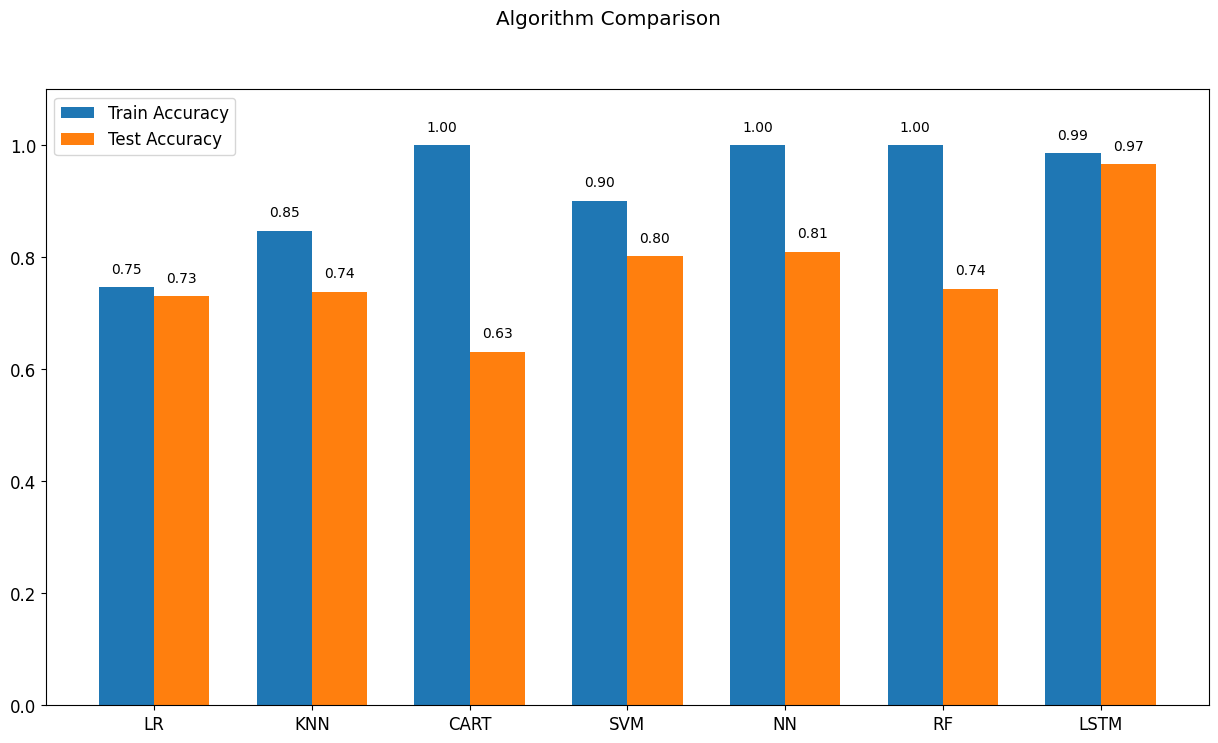

In [ ]:
plotResults(names, train_results, test_results)

As expected, the LSTM model has the best performance in the test set as compared to all other models that we saw before. Let us use LSTM model for the computation of the sentiments in the data.

In [ ]:
sequences_LSTM = tokenizer.texts_to_sequences(data_df['headline'])
X_LSTM = pad_sequences(sequences_LSTM, maxlen=50)

In [ ]:
Y_LSTM = model.predict(X_LSTM)

87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step


In [ ]:
data_df['sentiment_LSTM'] = Y_LSTM
corrlation = data_df['eventRet'].corr(data_df['sentiment_LSTM'])
print(corrlation)

0.09682563803090026


**As can be seen, the correlation improved to 12% from 4%**

## 4.3 - Unsupervised - Model based on financial lexicon ##

Lexicons are special dictionaries or vocabularies that have been created for analyzing sentiments. VADER (Valence Aware Dictionary for Entiment Reasoning) is a pre-built sentiment analysis model included in the NLTK package.

In [ ]:
# stock market lexicon
sia = SentimentIntensityAnalyzer()
stock_lex = pd.read_csv('/content/LexiconData.csv')
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

final_lex = {}
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

In [ ]:
text = "AAPL is trading higher after reporting its October sales rose 12.6% M/M. It has seen a 20%+ jump in orders"

In [ ]:
sia.polarity_scores(text)['compound']

0.4535

Now we extract the sentiment for the entire dataset.

In [ ]:
vader_sentiments = np.array([sia.polarity_scores(s)['compound'] for s in data_df['headline']])
print(vader_sentiments[:10])
print(vader_sentiments.shape)

[ 0.2115  0.8575  0.6971  0.7751 -0.0413  0.6199 -0.2997  0.7904  0.4896
  0.63  ]
(2759,)


In [ ]:
data_df['sentiment_lex'] = vader_sentiments

In [ ]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_lex'])
print('The correlation between the returns and lexicon is', corrlation)

The correlation between the returns and lexicon is 0.10516903773681391


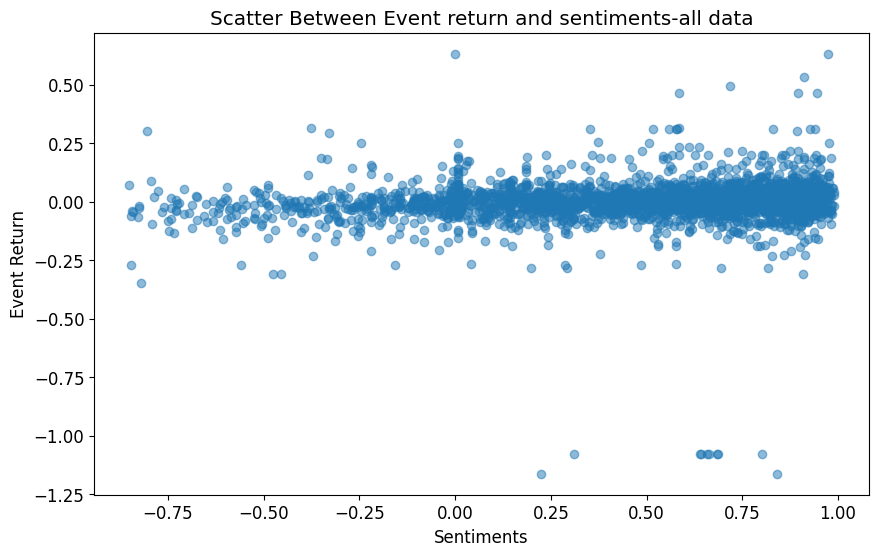

In [ ]:
plt.scatter(data_df['sentiment_lex'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

It can be seen that we don't have many high returns for lower sentiments, but the data may not be very clear. Let us look at the result for one of the stock tickers viz. Amazon

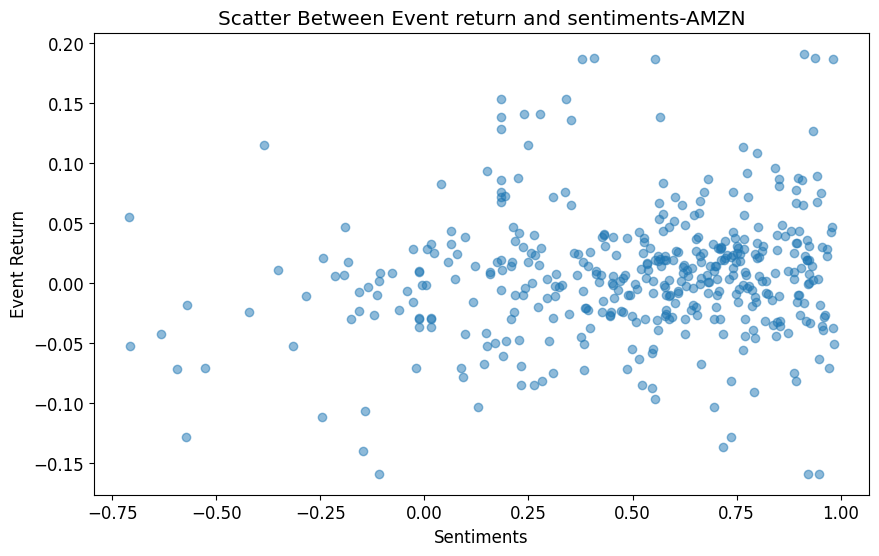

In [ ]:
data_df_stock  = data_df[data_df['ticker'] == 'AMZN']
plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AMZN')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

We see a positive correlation between the event return and sentiments. We will look deeper into the comparison of different types of the sentiment analysis in the next section.

In [ ]:
data_df.to_csv(r'Data\Step4_DataWithSentimentsResults.csv', sep='|', index=False)

## 4.4 Exploratory Data Analysis and comparison ##

In [ ]:
#Running EDA for the top SP500 companies
tickers = ['AAPL','MSFT','AMZN','GOOG','WMT','JPM','TSLA','NFLX','ADBE']
data_df = pd.read_csv(r'Data\Step4_DataWithSentimentsResults.csv', sep='|')
data_df = data_df[data_df['ticker'].isin(tickers)]

In [ ]:
data_new_df_stock=data_df[data_df['ticker']== 'NFLX'][['ticker','headline','sentiment_textblob','sentiment_LSTM','sentiment_lex']]
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(data_new_df_stock.head(1))

,ticker,headline,sentiment_textblob,sentiment_LSTM,sentiment_lex
1,NFLX,"Netflix (NFLX +1.1%) shares post early gains after Citigroup ups its rating to Buy and lifts its price target to $300 from $245. U.S. revenue growth is sustainable, Citi says, ""with a path to 50M subscribers by 2013,"" adding that NFLX has little competition in price, selection and convenience; mass market adoption of tablets will help, and the mass-market adoption phase is still to come.",-0.04375,0.999851,0.8575


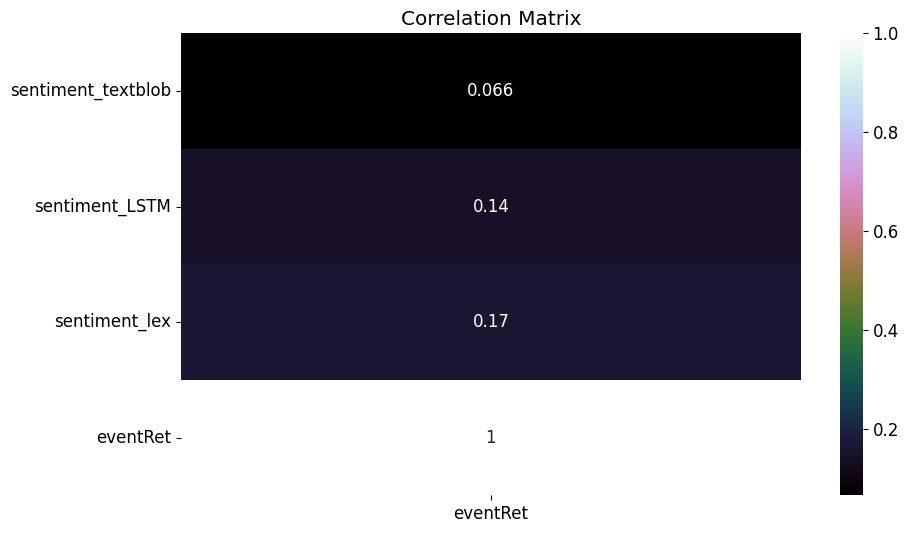

In [ ]:
#Plotting the result for Netflix
correlation = data_df[['sentiment_textblob','sentiment_LSTM','sentiment_lex','eventRet']].dropna(axis=0).corr()

plt.figure(figsize=(10,6))
plt.title('Correlation Matrix')
sns.heatmap(correlation[['eventRet']], vmax=1, annot=True,cmap='cubehelix')
plt.show()

**All the sentiments have positive relationship with the return which is intuitive and expected.**

In [ ]:
corr_data = []
for ticker in data_df['ticker'].unique():
    data_new_df_stock=data_df[data_df['ticker']==ticker]
    #Only look for the stocks with sufficient data
    if data_new_df_stock.shape[0] > 40 :
        corr_textblob= data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_textblob'])
        corr_LSTM = data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_LSTM'])
        corr_lex = data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_lex'])
        corr_data.append([ticker,corr_textblob, corr_LSTM, corr_lex])
    else:
        continue

In [ ]:
corr_df = pd.DataFrame(corr_data, columns =  ['ticker','corr_textblob','corr_LSTM','corr_lex'])
corr_df=corr_df.set_index('ticker')
corr_df.head(10)

,corr_textblob,corr_LSTM,corr_lex
ticker,,,
AMZN,0.019830,0.164903,0.134881
NFLX,0.092630,0.106394,0.224195
MSFT,-0.025318,0.180443,0.035703
GOOG,0.044213,0.178477,0.196290
JPM,-0.160327,0.072681,0.022992
TSLA,0.118400,0.176879,0.213664
AAPL,0.108476,0.229305,0.210533
WMT,0.186501,0.168880,0.105444
ADBE,0.033785,0.182767,0.130326


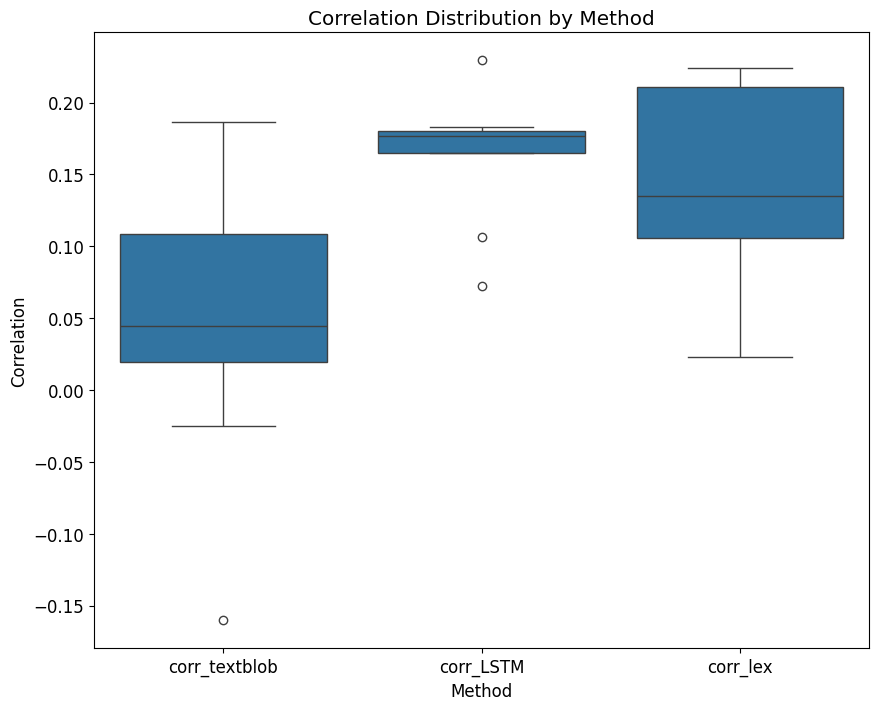

In [ ]:
# corr_df.loc[tickers].plot.bar(figsize = (10,8))

# Plot the bar chart for selected tickers
# ax = corr_df.loc[tickers].plot.bar(figsize=(10, 8), width=0.6)

# # Add the correlation values on top of each bar (above for positive, below for negative)
# for p in ax.patches:  # p is each individual bar (patch)
#     height = p.get_height()  # Get the height of the bar
#     # Position of the text depending on whether the bar is positive or negative
#     y_position = height + 0.005 if height > 0 else height - 0.01  # Adjust for negative bars
#     ax.text(p.get_x()+0.001 + p.get_width() / 2, y_position, f'{height:.2f}',
#             ha='center', va='bottom' if height > 0 else 'top', fontsize=7, color='black')

# # Set the y-axis limit to accommodate negative and positive values
# plt.ylim(corr_df.min().min() - 0.1, corr_df.max().max() + 0.1)  # Add a bit of padding

# # Add title and labels
# plt.title('Correlation Comparison for Selected Tickers')
# plt.xlabel('Tickers')
# plt.ylabel('Correlation')

# plt.show()
corr_df_long = corr_df.reset_index().melt(id_vars='ticker', value_vars=['corr_textblob', 'corr_LSTM', 'corr_lex'],
                                           var_name='Method', value_name='Correlation')

# Plot boxplot
plt.figure(figsize=(10, 8))
sns.boxplot(x='Method', y='Correlation', data=corr_df_long)

# Add title
plt.title('Correlation Distribution by Method')

# Show the plot
plt.show()

**Looking at the chart the correlation from the lexicon methodology is highest across all the stock tickers**

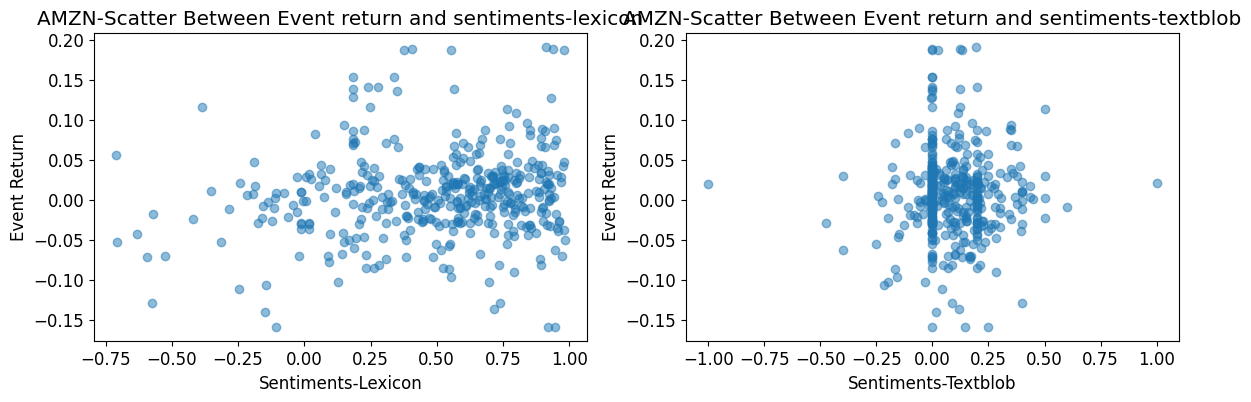

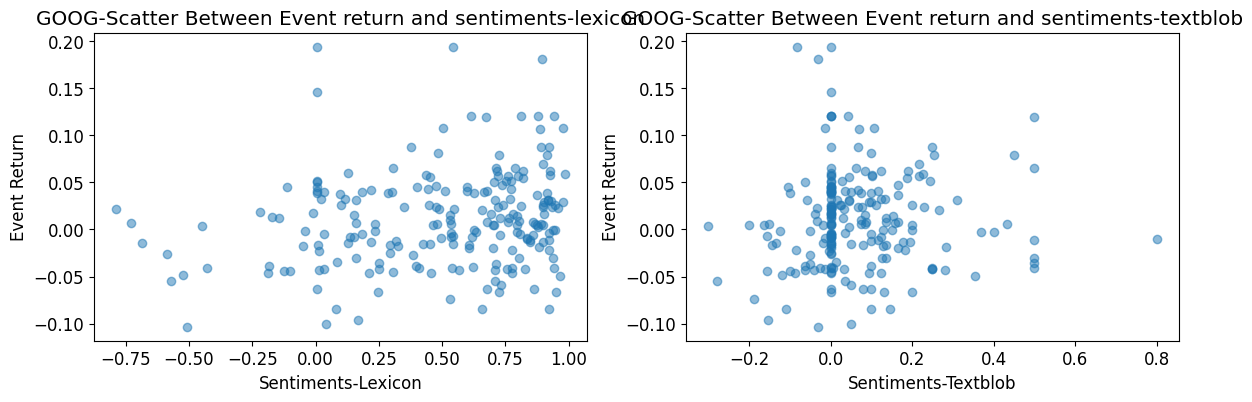

In [ ]:
#tickers = corr_df.nlargest(5,'corr_lex').index
for ticker in tickers[2:4]:
    data_df_stock  = data_df[data_df['ticker'] == ticker]
    fig = plt.figure(figsize=(14, 4), constrained_layout=False)

    plt.subplot(1, 2, 1)
    plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['eventRet'], alpha=0.5)
    plt.title(ticker + '-Scatter Between Event return and sentiments-lexicon')
    plt.ylabel('Event Return')
    plt.xlabel('Sentiments-Lexicon')


    plt.subplot(1, 2, 2)
    plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['eventRet'], alpha=0.5)
    plt.title(ticker + '-Scatter Between Event return and sentiments-textblob')
    plt.ylabel('Event Return')
    plt.xlabel('Sentiments-Textblob')
    plt.show()

**The lexicon based sentiments on the left definitely shows a positive relationship between the sentiments and return. We use lexicon based sentiments for the trading strategy in the next step.**

# 5. Model Evaluation- Building a Trading Strategy #

The sentiment data can be used in different ways for the trading strategy. Sentiment scores can be used as a directional signal and ideally create a long-short portfolio, by buying the stocks with positive score and selling the stocks with negative score. The sentiments can also be used as additional features over and above other features(such as correlated stocks, technical indicators) in a supervised learning model to predict the price or come up with a trading strategy.

In the trading strategy in this case study we buy and sell stock as per the current stock sentiments :

* Buy a stock when the change in sentiment score (Current sentiment score - previous sentiment score) is greater than .5 and sell a stock when the change in sentiment score is less than -.5.
* Additionally, we check for 15 days moving average while buying and selling and buy or sell in a unit of 100.

Obviusly, there can be many ways to create the trading strategy based in sentiments, by varying the threshold, or changing the number of units based on the initial cash available.

We use lexicon based sentiments for the trading strategy.

## 5.1. Setting up the strategy ##

Here we use backtrader which is a Python based API for writing and backtesting trading strategy. . Backtrader allows us to focus on writing reusable trading strategies, indicators and analyzers instead of having to spend time building infrastructure. we have a convenient framework to backtest and write our trading strategy. We used the Quickstart code in the docs (i.e. Refer to https://www.backtrader.com/docu/quickstart/quickstart/) as a base and modified it to include the sentiment scores.

We implement a simple strategy to buy if the previous day’s sentiment score increases by 0.5 from the last day and sell if it decreases by 0.5.

The following function contains two classes:

1. Sentiment:
2. SentimentStrat: The "next" function of this class implements the actual trading strategy.

In [ ]:
import backtrader as bt
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers

class Sentiment(bt.Indicator):
    lines = ('sentiment',)
    plotinfo = dict(
        plotymargin=0.5,
        plothlines=[0],
        plotyticks=[1.0, 0, -1.0])

    def next(self):
        self.sentiment = 0.0
        self.date = self.data.datetime
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        self.lines.sentiment[0] = self.sentiment


class SentimentStrat(bt.Strategy):
    params = (
        ('period', 15),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # Keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period)
        self.date = self.data.datetime
        self.sentiment = None
        Sentiment(self.data)
        self.plotinfo.plot = False


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    ### Main Strat ###
    def next(self):
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]

        # Check if an order is pending. if yes, we cannot send a 2nd one
        if self.order:
            return
        # If not in the market and previous sentiment not none
        if not self.position and prev_sentiment:
            # buy if current close more than sma AND sentiment increased by >= 0.5
            if self.dataclose[0] > self.sma[0] and self.sentiment - prev_sentiment >= 0.5:
                self.log('Previous Sentiment %.2f, New Sentiment %.2f BUY CREATE, %.2f' % (prev_sentiment, self.sentiment, self.dataclose[0]))
                self.order = self.buy()

        # Already in the market and previous sentiment not none
        elif prev_sentiment:
            # sell if current close less than sma AND sentiment decreased by >= 0.5
            if self.dataclose[0] < self.sma[0] and self.sentiment - prev_sentiment <= -0.5:
                self.log('Previous Sentiment %.2f, New Sentiment %.2f SELL CREATE, %.2f' % (prev_sentiment, self.sentiment, self.dataclose[0]))
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.period, self.broker.getvalue()), doprint=True)

In [ ]:
def plotBarPlots(df):
  df_transpose = df.T
  plt.figure(figsize=(12, 6))
  plt.bar(df_transposed.index, df_transposed['StrategyProfit'])
  plt.title('Strategy Profit for Each Ticker')
  plt.xlabel('Stock Ticker')
  plt.ylabel('Strategy Profit')
  plt.xticks(rotation=90)
  plt.show()


**Function for running the trading strategy**

Now, we write a generic function to run the strategy for any stock. We specified the “ticker” stock feeds to be pulled from Yahoo Finance, set an initial amount of $100,000, a fixed size of 100 lots per trade.

In [ ]:
def run_strategy(ticker, start, end):
    print(ticker)
    ticker = yf.Ticker(ticker)
    df_ticker = ticker.history(start = start, end = end)

    cerebro = bt.Cerebro()
    # Add the data
    cerebro.addstrategy(SentimentStrat)
    data = bt.feeds.PandasData(dataname=df_ticker)
    cerebro.adddata(data)
    start = 100000.0
    cerebro.broker.setcash(start)
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)
    print('Starting Portfolio Value: %.2f' % start)
    plt.rcParams['figure.figsize']=[10,6]
    plt.rcParams["font.size"]="12"
    cerebro.run()
    cerebro.plot(volume=False, iplot=True, plotname= ticker)
    end = cerebro.broker.getvalue()
    print('Start Portfolio value: %.2f\nFinal Portfolio Value: %.2f\nProfit: %.2f\n' \
          % (start, end, end - start))
    plt.show()
    return float(df_ticker['Close'].iloc[0]), (end - start)

## 5.2. Results for Individual Stocks ##

First running the strategy for google

In [ ]:
ticker = 'GOOG'
date_sentiment=data_df[data_df['ticker'].isin([ticker])]
date_sentiment=date_sentiment[['date','sentiment_lex']]
date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
date_sentiment=date_sentiment.to_dict()
run_strategy(ticker, start = '2012-01-01', end = '2018-12-12')

GOOG
Starting Portfolio Value: 100000.00
2012-04-12, Previous Sentiment 0.24, New Sentiment 0.80 BUY CREATE, 16.16
2012-04-13, BUY EXECUTED, Price: 16.07, Cost: 1607.06, Comm 0.00
2012-10-18, Previous Sentiment 0.98, New Sentiment 0.08 SELL CREATE, 17.25
2012-10-19, SELL EXECUTED, Price: 17.51, Cost: 1607.06, Comm 0.00
2012-10-19, OPERATION PROFIT, GROSS 144.02, NET 144.02
2013-01-10, Previous Sentiment 0.08, New Sentiment 0.80 BUY CREATE, 18.40
2013-01-11, BUY EXECUTED, Price: 18.41, Cost: 1841.46, Comm 0.00
2014-07-17, Previous Sentiment 0.73, New Sentiment -0.22 SELL CREATE, 28.51
2014-07-18, SELL EXECUTED, Price: 29.46, Cost: 1841.46, Comm 0.00
2014-07-18, OPERATION PROFIT, GROSS 1104.84, NET 1104.84
2014-07-18, Previous Sentiment -0.22, New Sentiment 0.77 BUY CREATE, 29.57
2014-07-21, BUY EXECUTED, Price: 29.40, Cost: 2940.09, Comm 0.00
2014-09-12, Previous Sentiment 0.66, New Sentiment -0.05 SELL CREATE, 28.60
2014-09-15, SELL EXECUTED, Price: 28.47, Cost: 2940.09, Comm 0.00
2014

<IPython.core.display.Javascript object>

Start Portfolio value: 100000.00
Final Portfolio Value: 102477.05
Profit: 2477.05



(16.5137939453125, 2477.049405255151)

## Finding for multiple stocks ##

In [ ]:
results_tickers = {}
for ticker in tickers:
    date_sentiment=data_df[data_df['ticker'].isin([ticker])]
    date_sentiment=date_sentiment[['date','sentiment_lex']]
    date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
    date_sentiment=date_sentiment.to_dict()
    results_tickers[ticker] = run_strategy(ticker, start = '2012-01-01', end = '2018-12-12')

AAPL
Starting Portfolio Value: 100000.00
2012-02-06, Previous Sentiment -0.17, New Sentiment 0.38 BUY CREATE, 13.98
2012-02-07, BUY EXECUTED, Price: 14.02, Cost: 1401.64, Comm 0.00
2012-04-13, Previous Sentiment 0.69, New Sentiment -0.74 SELL CREATE, 18.23
2012-04-16, SELL EXECUTED, Price: 18.38, Cost: 1401.64, Comm 0.00
2012-04-16, OPERATION PROFIT, GROSS 436.26, NET 436.26
2013-12-13, Previous Sentiment -0.38, New Sentiment 0.86 BUY CREATE, 17.27
2013-12-16, BUY EXECUTED, Price: 17.29, Cost: 1729.32, Comm 0.00
2014-09-25, Previous Sentiment 0.78, New Sentiment 0.04 SELL CREATE, 21.70
2014-09-26, SELL EXECUTED, Price: 21.85, Cost: 1729.32, Comm 0.00
2014-09-26, OPERATION PROFIT, GROSS 455.42, NET 455.42
2014-10-21, Previous Sentiment 0.14, New Sentiment 0.68 BUY CREATE, 22.72
2014-10-22, BUY EXECUTED, Price: 22.80, Cost: 2280.30, Comm 0.00
2015-06-11, Previous Sentiment 0.48, New Sentiment -0.42 SELL CREATE, 28.87
2015-06-12, SELL EXECUTED, Price: 28.78, Cost: 2280.30, Comm 0.00
2015-

In [ ]:
pd.DataFrame.from_dict(results_tickers).set_index([pd.Index(["PerUnitStartPrice", 'StrategyProfit'])])

,AAPL,MSFT,AMZN,GOOG,WMT,JPM,TSLA,NFLX,ADBE
PerUnitStartPrice,12.388999,21.120090,8.951500,16.513794,15.298916,24.284035,1.872000,10.320000,28.570000
StrategyProfit,1346.902697,3912.098164,3789.199829,2477.049405,346.717086,1790.130139,1050.333261,25180.713654,17027.000427


##5.4. Varying the strategy time period##

In this step we run the strategy for differnt time periods and look at the results. We first run it for the time period between 2012 and 2014.

In [ ]:
results_tickers = {}
for ticker in tickers:
    date_sentiment=data_df[data_df['ticker'].isin([ticker])]
    date_sentiment=date_sentiment[['date','sentiment_lex']]
    date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
    date_sentiment=date_sentiment.to_dict()
    results_tickers[ticker] = run_strategy(ticker, start = '2012-01-01', end = '2014-12-31')

AAPL
Starting Portfolio Value: 100000.00
2012-02-06, Previous Sentiment -0.17, New Sentiment 0.38 BUY CREATE, 13.98
2012-02-07, BUY EXECUTED, Price: 14.02, Cost: 1401.64, Comm 0.00
2012-04-13, Previous Sentiment 0.69, New Sentiment -0.74 SELL CREATE, 18.23
2012-04-16, SELL EXECUTED, Price: 18.38, Cost: 1401.64, Comm 0.00
2012-04-16, OPERATION PROFIT, GROSS 436.26, NET 436.26
2013-12-13, Previous Sentiment -0.38, New Sentiment 0.86 BUY CREATE, 17.27
2013-12-16, BUY EXECUTED, Price: 17.29, Cost: 1729.32, Comm 0.00
2014-09-25, Previous Sentiment 0.78, New Sentiment 0.04 SELL CREATE, 21.70
2014-09-26, SELL EXECUTED, Price: 21.85, Cost: 1729.32, Comm 0.00
2014-09-26, OPERATION PROFIT, GROSS 455.42, NET 455.42
2014-10-21, Previous Sentiment 0.14, New Sentiment 0.68 BUY CREATE, 22.72
2014-10-22, BUY EXECUTED, Price: 22.80, Cost: 2280.30, Comm 0.00
2014-12-30, (MA Period 15) Ending Value 101117.14
Start Portfolio value: 100000.00
Final Portfolio Value: 101117.14
Profit: 1117.14

MSFT
Starting 

In [ ]:
pd.DataFrame.from_dict(results_tickers).set_index([pd.Index(["StockPriceBeginning", 'StrategyProfit'])])

,AAPL,MSFT,AMZN,GOOG,WMT,JPM,TSLA,NFLX,ADBE
StockPriceBeginning,12.389000,21.120094,8.951500,16.513794,15.298920,24.284033,1.872000,10.320000,28.570000
StrategyProfit,1117.136375,594.815333,-143.650055,1155.397939,-98.128533,2197.786620,799.600077,2711.714172,3366.999817


**The strategy yield an overall profit for all the stocks except two. Now we run the strategy between 2016 and 2018.**

In [ ]:
results_tickers = {}
for ticker in tickers:
    date_sentiment=data_df[data_df['ticker'].isin([ticker])]
    date_sentiment=date_sentiment[['date','sentiment_lex']]
    date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
    date_sentiment=date_sentiment.to_dict()
    results_tickers[ticker] = run_strategy(ticker, start = '2016-01-01', end = '2018-12-31')

AAPL
Starting Portfolio Value: 100000.00
2016-03-15, Previous Sentiment 0.09, New Sentiment 0.66 BUY CREATE, 23.81
2016-03-16, BUY EXECUTED, Price: 23.82, Cost: 2382.15, Comm 0.00
2016-07-26, Previous Sentiment 0.93, New Sentiment 0.14 SELL CREATE, 22.15
2016-07-27, SELL EXECUTED, Price: 23.89, Cost: 2382.15, Comm 0.00
2016-07-27, OPERATION PROFIT, GROSS 6.71, NET 6.71
2016-12-13, Previous Sentiment 0.15, New Sentiment 0.74 BUY CREATE, 26.67
2016-12-14, BUY EXECUTED, Price: 26.63, Cost: 2663.50, Comm 0.00
2017-09-22, Previous Sentiment 0.58, New Sentiment 0.08 SELL CREATE, 35.60
2017-09-25, SELL EXECUTED, Price: 35.16, Cost: 2663.50, Comm 0.00
2017-09-25, OPERATION PROFIT, GROSS 852.39, NET 852.39
2017-11-06, Previous Sentiment 0.14, New Sentiment 0.64 BUY CREATE, 40.85
2017-11-07, BUY EXECUTED, Price: 40.77, Cost: 4076.60, Comm 0.00
2017-12-08, Previous Sentiment 0.57, New Sentiment -0.02 SELL CREATE, 39.84
2017-12-11, SELL EXECUTED, Price: 39.80, Cost: 4076.60, Comm 0.00
2017-12-11, 

In [ ]:
pd.DataFrame.from_dict(results_tickers).set_index([pd.Index(["PerUnitStartPrice", 'StrategyProfit'])])

,AAPL,MSFT,AMZN,GOOG,WMT,JPM,TSLA,NFLX,ADBE
PerUnitStartPrice,23.860577,48.337421,31.849501,36.959202,17.238346,49.64637,14.894000,109.959999,91.970001
StrategyProfit,-63.256523,3196.048240,2393.149757,1565.873454,191.857137,0.00000,725.733185,25019.999695,12551.000214


We see a good performance of the sentiment based strategy across all the stocks except AAPL and we can conclude that our sentiment based strategy performs quite well on different time period. The strategy can be further be tweaked to modify the threshold, order size. Additional metrics such as sharpe ratio and maximum drawdown can also be used to understand the performance of the strategy. The sentiments can also be used along with the other features such as correlated variables and technical indicators for prediction.

**Conclusion**

We performed a comparison of the models and concluded that one of the most important step is training the model for sentiment analysis is training it using the domain-specific vocabulary.

We further used the sentiments as signals to develop different trading strategy. This initial result suggests that the model trained on a financial lexicon based sentiments could prove a viable model for a trading strategy.

Additional improvements to this can be made by using more complex pre-trained sentiment analysis models such as Bert by google or diffeent pre-trained NLP models available in open source platforms. Existing NLP libraries fill in some of the pre-processing and encoding steps to allow us to focus on the inference step.

In [ ]:
results_tickers = {}
for ticker in tickers:
    date_sentiment=data_df[data_df['ticker'].isin([ticker])]
    date_sentiment=date_sentiment[['date','sentiment_lex']]
    date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
    date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
    date_sentiment=date_sentiment.to_dict()
    results_tickers[ticker] = run_strategy(ticker, start = '2018-01-01', end = '2020-12-31')

df_stocks = pd.DataFrame.from_dict(results_tickers).set_index([pd.Index(["PerUnitStartPrice", 'StrategyProfit'])])
df_stocks

AAPL
Starting Portfolio Value: 100000.00
2018-03-01, Previous Sentiment -0.07, New Sentiment 0.85 BUY CREATE, 41.34
2018-03-02, BUY EXECUTED, Price: 40.82, Cost: 4081.71, Comm 0.00
2018-03-28, Previous Sentiment 0.60, New Sentiment 0.09 SELL CREATE, 39.32
2018-03-29, SELL EXECUTED, Price: 39.64, Cost: 4081.71, Comm 0.00
2018-03-29, OPERATION PROFIT, GROSS -117.87, NET -117.87
2018-04-11, Previous Sentiment -0.23, New Sentiment 0.66 BUY CREATE, 40.73
2018-04-12, BUY EXECUTED, Price: 40.96, Cost: 4096.12, Comm 0.00
2018-04-24, Previous Sentiment 0.89, New Sentiment -0.23 SELL CREATE, 38.49
2018-04-25, SELL EXECUTED, Price: 38.41, Cost: 4096.12, Comm 0.00
2018-04-25, OPERATION PROFIT, GROSS -254.87, NET -254.87
2018-10-01, Previous Sentiment -0.35, New Sentiment 0.75 BUY CREATE, 54.08
2018-10-02, BUY EXECUTED, Price: 54.07, Cost: 5407.47, Comm 0.00
2018-10-10, Previous Sentiment 0.52, New Sentiment -0.11 SELL CREATE, 51.48
2018-10-11, SELL EXECUTED, Price: 51.05, Cost: 5407.47, Comm 0.00


,AAPL,MSFT,AMZN,GOOG,WMT,JPM,TSLA,NFLX,ADBE
PerUnitStartPrice,40.524349,79.633507,59.450500,53.059353,29.191181,88.111275,21.368668,201.070007,177.699997
StrategyProfit,-675.655329,1767.904303,8058.349609,502.943129,1876.452929,0.000000,21190.200424,-51.000977,0.000000


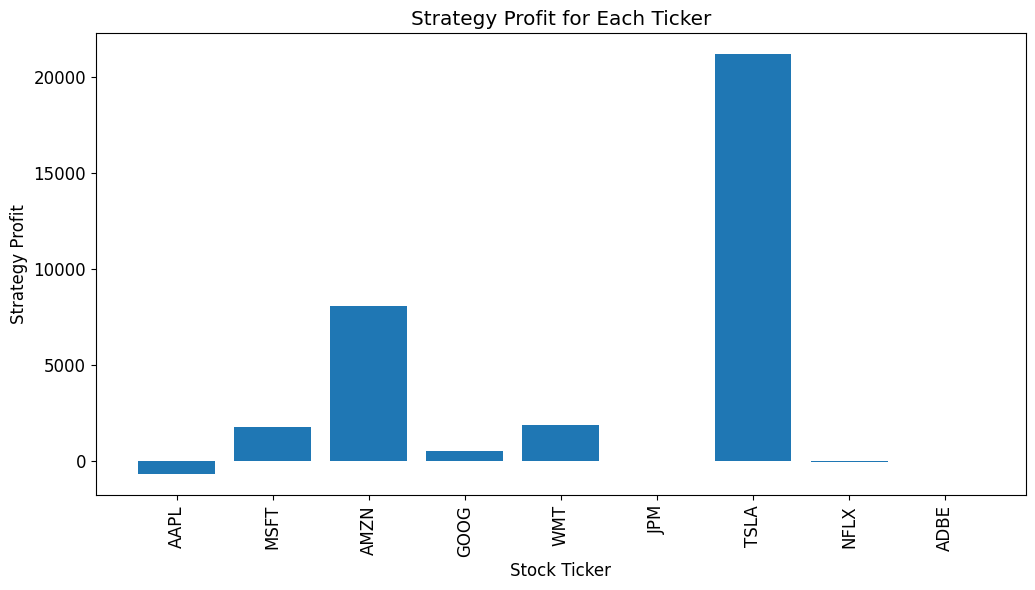

In [ ]:
df_transposed = df_stocks.T
plt.figure(figsize=(12, 6))
plt.bar(df_transposed.index, df_transposed['StrategyProfit'])
plt.title('Strategy Profit from 2018-2020')
plt.xlabel('Stock Ticker')
plt.ylabel('Strategy Profit')
plt.xticks(rotation=90)
plt.show()